In [1]:
#Import Libraries

import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Libraries that supports recommender system
from surprise import SVD, Dataset, accuracy, Reader, NormalPredictor, KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, LeaveOneOut
import matplotlib.pyplot as plt
import seaborn as sns


#Libraries that supports sentiment analysis
import numpy as np
import pandas as pd
from nltk.corpus import stopwords, brown
from nltk.stem import PorterStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from textblob import TextBlob

from sklearn.metrics import f1_score, accuracy_score
import time
from collections import defaultdict




In [2]:
#Read books and reviews json file - comics graphic

og_books = pd.read_json('goodreads_books_comics_graphic.json.gz',lines=True,compression='gzip')
og_reviews = pd.read_json('goodreads_reviews_comics_graphic.json.gz',lines=True,compression='gzip')

In [3]:
#Make a copy of original books and reviews dataframe 

books = og_books.copy()
reviews = og_reviews.copy()

In [4]:
#Filter required columns from the books and reviews dataframe

books = books.filter(['book_id','title_without_series','ratings_count','text_reviews_count','average_rating'], axis=1)
reviews = reviews.filter(["user_id", "book_id","review_id","rating","review_text"], axis = 1)

In [5]:
#Check if there is any null values in DFs'

reviews.isnull().sum()

user_id        0
book_id        0
review_id      0
rating         0
review_text    0
dtype: int64

In [6]:
books.isnull().sum()

book_id                 0
title_without_series    0
ratings_count           0
text_reviews_count      0
average_rating          0
dtype: int64

In [7]:
#Drop duplicates - removes duplicate rows if the user has rated a book more than once

reviews.drop_duplicates(['user_id', 'book_id'])

,user_id,book_id,review_id,rating,review_text
0,dc3763cdb9b2cae805882878eebb6a32,18471619,66b2ba840f9bd36d6d27f46136fe4772,3,Sherlock Holmes and the Vampires of London \n ...
1,bafc2d50014200cda7cb2b6acd60cd73,6315584,72f1229aba5a88f9e72f0dcdc007dd22,4,"I've never really liked Spider-Man. I am, howe..."
2,bafc2d50014200cda7cb2b6acd60cd73,29847729,a75309355f8662caaa5e2c92ab693d3f,4,"A very quick introduction, this is coming out ..."
3,bafc2d50014200cda7cb2b6acd60cd73,18454118,c3cc5a3e1d6b6c9cf1c044f306c8e752,5,I've been waiting so long for this. I first st...
4,bafc2d50014200cda7cb2b6acd60cd73,2239435,cc444be37ab0a42bfb4dd818cb5edd10,4,The only thing more entertaining than this boo...
...,...,...,...,...,...
542333,c9174473efac302c71adaa1ad2a46091,20176586,8e069a687dbecae9ffe7f5fa8772ac08,3,Bumping this up to a three star rating primari...
542334,64946797934367a178abe75e3febce66,11465282,77c383db515b63f84ad0f5de0cb5991d,3,The story didn't pull me in although I'm aware...
542335,bd575ed739592a8c20c346e5daa5ac76,31094296,9e059a74a7107fb57f5b45ded1abadb6,5,Stunning follow up. Once again it's not the ar...
542336,bd575ed739592a8c20c346e5daa5ac76,27404461,de2a13cd890ead821d846398239d5f1f,5,I grew up with the Terran Trade Authority book...


In [8]:
#Merge books and reviews dataframe based on book id

books_reviews_df = reviews.merge(books, on="book_id")

In [9]:
books_reviews_df.head()

,user_id,book_id,review_id,rating,review_text,title_without_series,ratings_count,text_reviews_count,average_rating
0,dc3763cdb9b2cae805882878eebb6a32,18471619,66b2ba840f9bd36d6d27f46136fe4772,3,Sherlock Holmes and the Vampires of London \n ...,Sherlock Holmes and the Vampires of London (Sh...,181,50,3.26
1,eaa54d876d841293059657fb80a9bba6,18471619,7dffb165871ddb916f2e0929981113b8,2,A graphic novel featuring Sherlock Holmes up a...,Sherlock Holmes and the Vampires of London (Sh...,181,50,3.26
2,da7a0c5ee0c89973224d8853445be68e,18471619,fad5f331499030af4f04f78183983235,3,12/31/13 Not as terrible as you might think. F...,Sherlock Holmes and the Vampires of London (Sh...,181,50,3.26
3,41b1c110d428bbc49481036e896c0a6f,18471619,09c342f31b94ee8f08c11578d8e3b370,2,Accepting as fact vampires are real with no ba...,Sherlock Holmes and the Vampires of London (Sh...,181,50,3.26
4,d7310760f68365d3ca747fa8b9310518,18471619,96a5d05b6847875a49c3802ee469a2bd,2,This graphic novel has Sherlock Holmes taking ...,Sherlock Holmes and the Vampires of London (Sh...,181,50,3.26


In [10]:
books_reviews_df.shape

(542338, 9)

In [11]:
#Drop rows with rating 0 - not available
books_reviews_df = books_reviews_df[books_reviews_df.rating != 0]

#Select items that has more than 20 rating
books_reviews_df = books_reviews_df[books_reviews_df['ratings_count'] > 20] 

#Select items that has more than one review
books_reviews_df = books_reviews_df[books_reviews_df['text_reviews_count'] > 1] 

#select rows with users that has rated more than 50 books
books_reviews_df = books_reviews_df[books_reviews_df['user_id'].map(books_reviews_df['user_id'].value_counts()) > 50] 

In [12]:
books_reviews_df.shape

(231164, 9)

In [13]:
#Number of unique users and books in the dataset

print("Number of Unique Users: {0}".format(books_reviews_df['user_id'].nunique()))
print("Number of Unique Books: {0}".format(books_reviews_df['book_id'].nunique()))

Number of Unique Users: 1665
Number of Unique Books: 44209


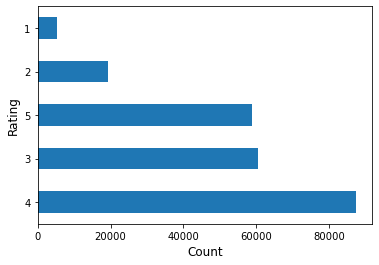

In [14]:
books_reviews_df['rating'].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()

In [15]:
#Rename user id with unique integer values

books_reviews_df['userid'] = books_reviews_df.user_id.astype('category').cat.rename_categories(range(1, books_reviews_df.user_id.nunique()+1))

In [16]:
books_reviews_df['userid'].nunique()

1665

SENTIMENT ANALYSIS

1)LOWER CASE USER REVIEWS <br>
2)REMOVE SYMBOLS AND DIGITS <br>
3)REMOVE STOP WORDS <br>
4)PERFORM LEMMATIZATION <br>
5)GENERATE SENTIMENT POLARITY VALUES USING TEXTBLOB <br>

In [17]:
#Lowercase user reviews

books_reviews_df['clean_review_text'] = books_reviews_df['review_text'].str.lower()

In [18]:
#Remove symbols and digits from the text

books_reviews_df['clean_review_text'] = [re.sub("[^A-Za-z]", " ", ' '.join(w.split('\\n'))).split() for w in books_reviews_df['clean_review_text']]

In [19]:
#Funtion to remove stopwords - words that does not add sense in predictions eg: is, a, and

stop_words = set(stopwords.words('english'))

def remove_stopword(text):
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

In [20]:
#Remove stopwords and perform lemmatization to restore words to their root form

lemmatizer = WordNetLemmatizer()
books_reviews_df["clean_review_text"] = [[lemmatizer.lemmatize(w) for w in sentence if lemmatizer.lemmatize(w) not in stop_words] for sentence in books_reviews_df['clean_review_text']]


In [21]:
books_reviews_df['clean_review_text'].iloc[0]

['graphic',
 'novel',
 'featuring',
 'sherlock',
 'holmes',
 'vampire',
 'treat',
 'read',
 'book',
 'make',
 'cardinal',
 'sin',
 'simply',
 'boring',
 'lot',
 'ha',
 'artwork',
 'suspect',
 'artist',
 'try',
 'cram',
 'many',
 'panel',
 'onto',
 'many',
 'page',
 'reduces',
 'quality',
 'art',
 'point',
 'much',
 'story',
 'incomprehensible',
 'added',
 'muddy',
 'quality',
 'limited',
 'colour',
 'palette',
 'many',
 'panel',
 'see',
 'going',
 'lot',
 'time',
 'writer',
 'must',
 'share',
 'blame',
 'though',
 'putting',
 'much',
 'text',
 'already',
 'small',
 'panel',
 'much',
 'text',
 'musing',
 'sherlock',
 'holmes',
 'rather',
 'conversation',
 'also',
 'strip',
 'story',
 'mystery',
 'reason',
 'john',
 'watson',
 'writes',
 'holmes',
 'case',
 'holmes',
 'refuse',
 'arthur',
 'conan',
 'doyle',
 'maintained',
 'much',
 'central',
 'mystery',
 'sherlock',
 'holmes',
 'really',
 'however',
 'privy',
 'many',
 'holmes',
 'thought',
 'book',
 'make',
 'le',
 'mysterious',
 'sup

In [22]:
#Convert the preprocessed text to string

books_reviews_df['clean_review_text'] = books_reviews_df['clean_review_text'].astype(str)

In [23]:
#Textblob function to generate the polarity values of the text 

def textblob_score(text: str) -> float:
    return TextBlob(text).sentiment.polarity

In [24]:
#Store the sentiment Polarity value in a separate column called score
books_reviews_df['score'] = books_reviews_df.apply(lambda row: textblob_score(row['clean_review_text']), axis=1)
    
#Convert float score to category based on 5 bins
books_reviews_df['review_rating'] = pd.cut(books_reviews_df['score'], bins=5, labels=[1, 2, 3, 4, 5])

#Convert float score to category based on binary values
books_reviews_df['binary_review_rating'] = pd.cut(books_reviews_df['score'], bins=2, labels=[-1,1])

#Drop score column as it is not needed anymore
books_reviews_df = books_reviews_df.drop('score', axis=1)

In [25]:
#Convert the numeric rating into binary values - rating from 1 to 3 are replaced with -1; rating 4 and 5 are replace with 1

books_reviews_df.loc[books_reviews_df["rating"] > 3, "binary_rating"] = '1'
books_reviews_df.loc[books_reviews_df["rating"] < 4, "binary_rating"] = '-1'

Five main columns used in the further steps are:

user id <br>

rating: numeric rating ranging from 1 to 5 <br>
review_rating: rating scores generated using sentiment analysis ranging from 1 to 5 <br>

binary_rating: numeric ratings converted to binary values 1 and -1 <br>
binary_review_rating: rating scores generated using sentiment analysis as 1 and -1 <br>

Each sets are used individually 

In [26]:
books_reviews_df['rating'].value_counts()

4    87406
3    60472
5    58680
2    19408
1     5198
Name: rating, dtype: int64

In [27]:
#review rating
books_reviews_df['review_rating'].value_counts()

3    128306
4     88856
5      7071
2      5788
1      1143
Name: review_rating, dtype: int64

In [28]:
books_reviews_df['binary_rating'].value_counts()

1     146086
-1     85078
Name: binary_rating, dtype: int64

In [29]:
books_reviews_df['binary_review_rating'].value_counts()

1     181583
-1     49581
Name: binary_review_rating, dtype: int64

In [30]:
#Convert the binary rating to integer

books_reviews_df["binary_rating"] = pd.to_numeric(books_reviews_df["binary_rating"])

In [31]:
print("Highest number of books that a user rated is ", books_reviews_df['user_id'].value_counts().max())

Highest number of books that a user rated is  2728


In [31]:
books_reviews_df.head()

,user_id,book_id,review_id,rating,review_text,title_without_series,ratings_count,text_reviews_count,average_rating,userid,clean_review_text,review_rating,binary_review_rating,binary_rating
1,eaa54d876d841293059657fb80a9bba6,18471619,7dffb165871ddb916f2e0929981113b8,2,A graphic novel featuring Sherlock Holmes up a...,Sherlock Holmes and the Vampires of London (Sh...,181,50,3.26,1519,"['graphic', 'novel', 'featuring', 'sherlock', ...",3,1,-1
2,da7a0c5ee0c89973224d8853445be68e,18471619,fad5f331499030af4f04f78183983235,3,12/31/13 Not as terrible as you might think. F...,Sherlock Holmes and the Vampires of London (Sh...,181,50,3.26,1423,"['terrible', 'might', 'think', 'full', 'review...",2,-1,-1
3,41b1c110d428bbc49481036e896c0a6f,18471619,09c342f31b94ee8f08c11578d8e3b370,2,Accepting as fact vampires are real with no ba...,Sherlock Holmes and the Vampires of London (Sh...,181,50,3.26,426,"['accepting', 'fact', 'vampire', 'real', 'back...",4,1,-1
4,d7310760f68365d3ca747fa8b9310518,18471619,96a5d05b6847875a49c3802ee469a2bd,2,This graphic novel has Sherlock Holmes taking ...,Sherlock Holmes and the Vampires of London (Sh...,181,50,3.26,1395,"['graphic', 'novel', 'ha', 'sherlock', 'holmes...",3,-1,-1
9,d286122fed6ded84ff53993335bfd59c,18471619,304ddfb1335bca322d8a8c400767d49d,3,"This ""ahistorical"" Sherlock Holmes tale takes ...",Sherlock Holmes and the Vampires of London (Sh...,181,50,3.26,1366,"['ahistorical', 'sherlock', 'holmes', 'tale', ...",3,1,-1


In [32]:
def accuracy(df: pd.DataFrame, actual_str, predicted_str):
    acc = accuracy_score(df[actual_str], df[predicted_str])*100
    f1 = f1_score(df[actual_str], df[predicted_str], average='macro')
    print("Accuracy: {}\nMacro F1-score: {}".format(acc, f1))

In [33]:
#Find accuracy of the sentiment scores generated
accuracy(books_reviews_df, 'rating', 'review_rating')

Accuracy: 33.98972158294544
Macro F1-score: 0.21101585812591042


In [34]:
#Find accuracy of the sentiment scores generated
accuracy(books_reviews_df, 'binary_rating', 'binary_review_rating')

Accuracy: 61.47107681126819
Macro F1-score: 0.5333873244149039


In [35]:
#Nominal scale data

reader = Reader(rating_scale=(-1,1))
rating_data = Dataset.load_from_df(books_reviews_df[['userid', 'book_id', 'binary_rating']], reader)
review_data = Dataset.load_from_df(books_reviews_df[['userid', 'book_id', 'binary_review_rating']], reader)

Rating

In [36]:
#Hyper parameter tuning using gridsearch for svd algorithm for review data

start_time = time.time()

svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}

rating_svd = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)
rating_svd.fit(rating_data)

# best accuracy score
print("SVD RMSE: {0}".format(rating_svd.best_score['rmse']))
print("SVD MAE: {0}".format(rating_svd.best_score['mae']))


# svd combination of parameters that gave the best RMSE score
print("SVD Best Parameters RMSE: {0}".format(rating_svd.best_params['rmse']))

# svd combination of parameters that gave the best MAE score
print("SVD Best Parameters MAE: {0}".format(rating_svd.best_params['mae']))

computational_time = time.time() - start_time

print("computational time: %0.2fs" %(computational_time))

SVD RMSE: 0.8791483584275603
SVD MAE: 0.7976472293544351
SVD Best Parameters RMSE: {'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.4}
SVD Best Parameters MAE: {'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.4}
computational time: 483.82s


In [37]:
#Hyper parameter tuning using gridsearch for KNN algorithm for rating data

start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                                  'reg': [1, 2]},
                  'k': [10, 15, 20, 25],
                  'sim_options': {'name': ['msd', 'cosine'],
                                  'min_support': [1, 5]}
                 }
rating_knn_basic = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5)
rating_knn_means = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5)
rating_knn_baseline = GridSearchCV(KNNBaseline, knn_param_grid, measures=['rmse', 'mae'], cv=5)

rating_knn_basic.fit(rating_data)
rating_knn_means.fit(rating_data)
rating_knn_baseline.fit(rating_data)

# best accuracy score for KNNBasic
print("KNNBasic RMSE: {0}".format(rating_knn_basic.best_score['rmse']))
print("KNNBasic MAE: {0}".format(rating_knn_basic.best_score['mae']))

# best accuracy score for KNNWithMeans
print("KNNWithMeans RMSE: {0}".format(rating_knn_means.best_score['rmse']))
print("KNNWithMeans MAE: {0}".format(rating_knn_means.best_score['mae']))

# best accuracy score for KNNBaseline
print("KNNBaseline RMSE: {0}".format(rating_knn_baseline.best_score['rmse']))
print("KNNBaseline MAE: {0}".format(rating_knn_baseline.best_score['mae']))

# combination of parameters that gave the best RMSE score
print("KNNBasic Best Parameters RMSE: {0}".format(rating_knn_basic.best_params['rmse']))
print("KNNWithMeans Best Parameters RMSE: {0}".format(rating_knn_means.best_params['rmse']))
print("KNNBaseline Best Parameters RMSE: {0}".format(rating_knn_baseline.best_params['rmse']))

# combination of parameters that gave the best MAE score
print("KNNBasic Best Parameters MAE: {0}".format(rating_knn_basic.best_params['mae']))
print("KNNWithMeans Best Parameters MAE: {0}".format(rating_knn_means.best_params['mae']))
print("KNNBaseline Best Parameters MAE: {0}".format(rating_knn_baseline.best_params['mae']))


computational_time = time.time() - start_time
print("computational time: %0.2fs" %(computational_time))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


In [38]:
#cross validation for rating data

rating_best_svd = rating_svd.best_estimator['rmse']
rating_best_knnbasic = rating_knn_basic.best_estimator['rmse']
rating_best_knnmeans = rating_knn_means.best_estimator['rmse']
rating_best_knnbaseline = rating_knn_baseline.best_estimator['rmse']


benchmark = []

for algorithm in [rating_best_svd, rating_best_knnbasic, rating_best_knnmeans, rating_best_knnbaseline]:
    results = cross_validate(algorithm, rating_data, measures=['RMSE'], cv=5, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm')


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity ma

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.879222,17.015018,0.446713
KNNBasic,0.982588,0.404659,1.884872
KNNWithMeans,0.923641,0.481390,1.884400
KNNBaseline,0.915696,1.242642,1.997975


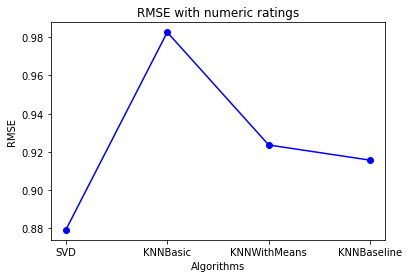

In [58]:
rmse = [0.879222, 0.982588, 0.923641, 0.915696]
algos = ['SVD', 'KNNBasic', "KNNWithMeans", 'KNNBaseline']
plt.plot(algos, rmse, '-bo')
plt.xlabel("Algorithms")
plt.ylabel("RMSE")
plt.title("RMSE with numeric ratings")
plt.show()

In [39]:
#Hyper parameter tuning using gridsearch for svd algorithm for review data

start_time = time.time()

svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}

review_svd = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)
review_svd.fit(review_data)

# best accuracy score
print("SVD RMSE: {0}".format(review_svd.best_score['rmse']))
print("SVD MAE: {0}".format(review_svd.best_score['mae']))


# svd combination of parameters that gave the best RMSE score
print("SVD Best Parameters RMSE: {0}".format(review_svd.best_params['rmse']))

# svd combination of parameters that gave the best MAE score
print("SVD Best Parameters MAE: {0}".format(review_svd.best_params['mae']))

computational_time = time.time() - start_time
print("computational time: %0.2fs" %(computational_time))

SVD RMSE: 0.7398865805596758
SVD MAE: 0.5670173558956991
SVD Best Parameters RMSE: {'n_epochs': 25, 'lr_all': 0.002, 'reg_all': 0.4}
SVD Best Parameters MAE: {'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.4}
computational time: 517.03s


In [40]:
#Hyper parameter tuning using gridsearch for KNN algorithm for review data

start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                                  'reg': [1, 2]},
                  'k': [10, 15, 20, 25],
                  'sim_options': {'name': ['msd', 'cosine'],
                                  'min_support': [1, 5]}
                 }
review_knn_basic = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5)
review_knn_basic.fit(review_data)


review_knn_means = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5)
review_knn_means.fit(review_data)


review_knn_baseline = GridSearchCV(KNNBaseline, knn_param_grid, measures=['rmse', 'mae'], cv=5)
review_knn_baseline.fit(review_data)


# best accuracy score for KNNBasic
print("KNNBasic RMSE: {0}".format(review_knn_basic.best_score['rmse']))
print("KNNBasic MAE: {0}".format(review_knn_basic.best_score['mae']))

# best accuracy score for KNNWithMeans
print("KNNWithMeans RMSE: {0}".format(review_knn_means.best_score['rmse']))
print("KNNWithMeans MAE: {0}".format(review_knn_means.best_score['mae']))

# best accuracy score for KNNBaseline
print("KNNBaseline RMSE: {0}".format(review_knn_baseline.best_score['rmse']))
print("KNNBaseline MAE: {0}".format(review_knn_baseline.best_score['mae']))

# combination of parameters that gave the best RMSE score
print("KNNBasic Best Parameters RMSE: {0}".format(review_knn_basic.best_params['rmse']))
print("KNNWithMeans Best Parameters RMSE: {0}".format(review_knn_means.best_params['rmse']))
print("KNNBaseline Best Parameters RMSE: {0}".format(review_knn_baseline.best_params['rmse']))

# combination of parameters that gave the best MAE score
print("KNNBasic Best Parameters MAE: {0}".format(review_knn_basic.best_params['mae']))
print("KNNWithMeans Best Parameters MAE: {0}".format(review_knn_means.best_params['mae']))
print("KNNBaseline Best Parameters MAE: {0}".format(review_knn_baseline.best_params['mae']))


computational_time = time.time() - start_time
print("computational time: %0.2fs" %(computational_time))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


In [42]:
#cross validation for review data

review_best_svd = review_svd.best_estimator['rmse']
review_best_knnbasic = review_knn_basic.best_estimator['rmse']
review_best_knnmeans = review_knn_means.best_estimator['rmse']
review_best_knnbaseline = review_knn_baseline.best_estimator['rmse']


benchmark = []

for algorithm in [review_best_svd, review_best_knnbasic, review_best_knnmeans, review_best_knnbaseline]:
    results = cross_validate(algorithm, review_data, measures=['RMSE'], cv=5, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm')



Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the ms

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.739898,14.090530,0.311576
KNNBasic,0.863216,1.008113,1.883709
KNNWithMeans,0.800713,0.463487,2.177913
KNNBaseline,0.787928,1.215142,1.963745


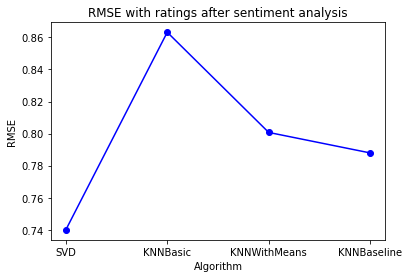

In [59]:
rmse = [0.739898, 0.863216, 0.800713, 0.787928]
algos = ['SVD', 'KNNBasic', "KNNWithMeans", 'KNNBaseline']
plt.plot(algos, rmse, '-bo')
plt.xlabel("Algorithm")
plt.ylabel("RMSE")
plt.title("RMSE with ratings after sentiment analysis")
plt.show()


In [43]:
cross_validate(rating_best_svd, rating_data, measures = ['RMSE'], cv = 5, verbose = True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8801  0.8786  0.8775  0.8796  0.8800  0.8792  0.0010  
Fit time          13.19   12.73   12.22   13.46   12.73   12.87   0.43    
Test time         0.29    0.22    0.26    0.26    1.30    0.46    0.42    


{'test_rmse': array([0.88014463, 0.87859545, 0.87745847, 0.87959507, 0.88004571]),
 'fit_time': (13.19220781326294,
  12.72959017753601,
  12.223484992980957,
  13.461912155151367,
  12.726683855056763),
 'test_time': (0.28818202018737793,
  0.21716570854187012,
  0.25638294219970703,
  0.26009607315063477,
  1.3000719547271729)}

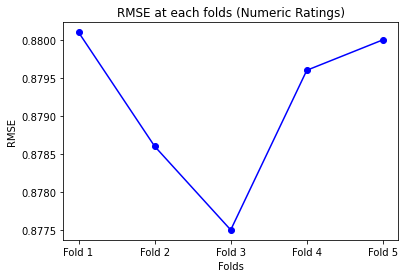

In [61]:
rmse = [0.8801, 0.8786, 0.8775, 0.8796, 0.8800]
algos = ['Fold 1', 'Fold 2', "Fold 3", 'Fold 4', 'Fold 5']
plt.plot(algos, rmse, '-bo')
plt.xlabel("Folds")
plt.title("RMSE at each folds (Numeric Ratings)")
plt.ylabel("RMSE")
plt.show()


In [44]:
cross_validate(review_best_svd, review_data, measures = ['RMSE'], cv = 5, verbose = True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7432  0.7408  0.7394  0.7364  0.7398  0.7399  0.0022  
Fit time          14.48   13.46   12.77   12.43   13.57   13.34   0.71    
Test time         0.30    0.26    1.31    0.25    0.26    0.48    0.42    


{'test_rmse': array([0.74317554, 0.7407912 , 0.73937223, 0.73636401, 0.73980848]),
 'fit_time': (14.482821702957153,
  13.460434198379517,
  12.771977186203003,
  12.43357229232788,
  13.565560102462769),
 'test_time': (0.30433201789855957,
  0.25803279876708984,
  1.30796217918396,
  0.2503550052642822,
  0.2621419429779053)}

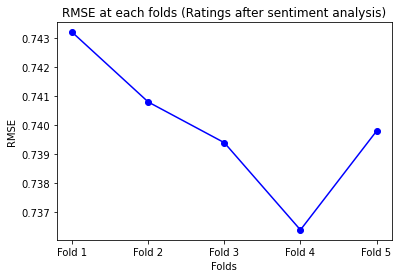

In [60]:
rmse = [0.7432, 0.7408, 0.7394, 0.7364, 0.7398]
algos = ['Fold 1', 'Fold 2', "Fold 3", 'Fold 4', 'Fold 5']
plt.plot(algos, rmse, '-bo')
plt.xlabel("Folds")
plt.title("RMSE at each folds (Ratings after sentiment analysis)")
plt.ylabel("RMSE")
plt.show()

In [45]:
"code cited from: https://surprise.readthedocs.io/en/stable/FAQ.html"

from collections import defaultdict

from surprise import Dataset, SVD

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [47]:
# Top N recommendations using numeric ratings

rating_trainset = rating_data.build_full_trainset()
rating_best_svd.fit(rating_trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
rating_testset = rating_trainset.build_anti_testset()
rating_predictions = rating_best_svd.test(rating_testset)

rating_top_n = get_top_n(rating_predictions, n=10)


In [48]:
# Top N recommendations using ratins after sentiment analysis

review_trainset = review_data.build_full_trainset()
review_best_svd.fit(review_trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
review_testset = review_trainset.build_anti_testset()
review_predictions = review_best_svd.test(review_testset)

review_top_n = get_top_n(review_predictions, n=10)


In [123]:
# Top N recommendations of user 1423 and 1519

for uid, user_ratings in rating_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    if (uid == 1423):
        break

for uid, user_ratings in review_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    if (uid == 1423):
        break


1519 [60113, 31670261, 8569434, 11381638, 13228306, 25363212, 6700070, 22823536, 33517044, 13591145]
1423 [60113, 8569434, 31670261, 11381638, 13228306, 25363212, 22823536, 33517044, 13591145, 22078240]
1519 [28503853, 8693600, 1702887, 10149910, 22822839, 27414475, 7059447, 196924, 1261277, 21535713]
1423 [1702887, 1261277, 28503853, 10149910, 22822839, 31371502, 18373339, 667985, 8103702, 6662883]


In [133]:
for uid, user_ratings in review_top_n.items():
    userid = uid
    item_id = [iid for (iid, _) in user_ratings]
    pred_rating = [est for (_, est) in user_ratings]
    if (uid == 1423):
        break

In [134]:
result_df = books_reviews_df[books_reviews_df['book_id'].isin(item_id)]
result_df = result_df.filter(['book_id','title_without_series','ratings_count','average_rating'], axis=1)
result_df = result_df.drop_duplicates()
result_df

,book_id,title_without_series,ratings_count,average_rating
116902,6662883,Oz: The Wonderful Wizard of Oz,24625,4.08
117042,28503853,Narwhal: Unicorn of the Sea (A Narwhal and Je...,1628,4.22
143583,22822839,The Thrilling Adventures of Lovelace and Babba...,2463,4.05
223333,18373339,"American Vampire, Vol. 6",1440,3.74
270782,667985,"Chobits, Vol. 1",34730,4.05
272539,10149910,Mangaman,658,3.37
299089,1702887,"Bride of the Water God, Volume 1",4588,3.94
299523,8103702,The Extraordinary Adventures of Adèle Blanc-Se...,638,3.42
301313,1261277,"Nodame Cantabile, Vol. 1 (Nodame Cantabile, #1)",5624,4.18
305727,31371502,Invisible Emmie,1143,3.90


In [131]:
for uid, user_ratings in rating_top_n.items():
    userid = uid
    item_id = [iid for (iid, _) in user_ratings]
    pred_rating = [est for (_, est) in user_ratings]
    if (uid == 1423):
        break

In [132]:
result_df = books_reviews_df[books_reviews_df['book_id'].isin(item_id)]
result_df = result_df.filter(['book_id','title_without_series','ratings_count','average_rating'], axis=1)
result_df = result_df.drop_duplicates()
result_df

,book_id,title_without_series,ratings_count,average_rating
70143,33517044,All's Faire in Middle School,1640,4.18
78278,22078240,Saga: Book One,4201,4.70
90548,25363212,Becoming Unbecoming,926,4.31
101003,8569434,"Scalped, Vol. 7: Rez Blues (Scalped, #7)",1670,4.35
184017,22823536,"Velvet, Vol. 2: The Secret Lives of Dead Men (...",1561,4.25
203908,11381638,"Criminal, Vol. 6: The Last of the Innocent",1892,4.38
211067,13228306,"Scalped, Vol. 9: Knuckle Up (Scalped, #9)",1397,4.40
267283,31670261,The Singing Bones,648,4.21
267388,13591145,Economix: How and Why Our Economy Works (and D...,1876,4.31
348589,60113,"Making Comics: Storytelling Secrets of Comics,...",6197,4.29


In [49]:
"code cited from: https://surprise.readthedocs.io/en/latest/FAQ.html#how-to-compute-precision-k-and-recall-k"

def precision_recall_at_k(predictions, k=10, threshold=0):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


Precision and recall for rating data

In [50]:
#Calculate precision and recall for top 5 recommendation using 5 folds

svd_kf_5 = KFold(n_splits=5)

svd_kf_5_5_precision = []
svd_kf_5_5_recall = []
svd_kf_5_5_f1 = []

#mean precision and recall with top 5 recommendation and 5 Fold 

for trainset, testset in svd_kf_5.split(rating_data):
    rating_best_svd.fit(trainset)
    predictions = rating_best_svd.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=0)

    # Precision and recall can then be averaged over all users
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = (1+0.25) * ((precision * recall) / ((0.25 * precision) + recall))
    
    svd_kf_5_5_precision.append(precision)
    svd_kf_5_5_recall.append(recall)
    svd_kf_5_5_f1.append(f1)

print("Precision for 5 fold top 5 recommendation: {0}".format(sum(svd_kf_5_5_precision) / len(svd_kf_5_5_precision)))
print("Recall for 5 fold top 5 recommendation: {0}".format(sum(svd_kf_5_5_recall) / len(svd_kf_5_5_recall)))
print("F1 for 5 fold top 5 recommendation: {0}".format(sum(svd_kf_5_5_f1) / len(svd_kf_5_5_f1)))


Precision for 5 fold top 5 recommendation: 0.7759779779779704
Recall for 5 fold top 5 recommendation: 0.3344215877536527
F1 for 5 fold top 5 recommendation: 0.6138696434443459


In [51]:
svd_kf_5_10_precision = []
svd_kf_5_10_recall = []
svd_kf_5_10_f1 = []

#mean precision and recall with top 10 recommendation and 5 Fold 

for trainset, testset in svd_kf_5.split(rating_data):
    rating_best_svd.fit(trainset)
    predictions = rating_best_svd.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=0)

    # Precision and recall can then be averaged over all users
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = (1+0.25) * ((precision * recall) / ((0.25 * precision) + recall))
    
    svd_kf_5_10_precision.append(precision)
    svd_kf_5_10_recall.append(recall)
    svd_kf_5_10_f1.append(f1)

print("Precision for 5 fold top 10 recommendation: {0}".format(sum(svd_kf_5_10_precision) / len(svd_kf_5_10_precision)))
print("Recall for 5 fold top 10 recommendation: {0}".format(sum(svd_kf_5_10_recall) / len(svd_kf_5_10_recall)))
print("F1 for 5 fold top 10 recommendation: {0}".format(sum(svd_kf_5_10_f1) / len(svd_kf_5_10_f1)))


Precision for 5 fold top 10 recommendation: 0.7384106010772675
Recall for 5 fold top 10 recommendation: 0.5681678893051282
F1 for 5 fold top 10 recommendation: 0.6966557692346683


In [52]:
svd_kf_10 = KFold(n_splits=10)

svd_kf_10_5_precision = []
svd_kf_10_5_recall = []
svd_kf_10_5_f1 = []

#mean precision and recall with top 5 recommendation and 10 Fold 

for trainset, testset in svd_kf_10.split(rating_data):
    rating_best_svd.fit(trainset)
    predictions = rating_best_svd.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=0)

   # Precision and recall can then be averaged over all users
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = (1+0.25) * ((precision * recall) / ((0.25 * precision) + recall))
    
    svd_kf_10_5_precision.append(precision)
    svd_kf_10_5_recall.append(recall)
    svd_kf_10_5_f1.append(f1)


print("Precision for 10 fold top 5 recommendation: {0}".format(sum(svd_kf_10_5_precision) / len(svd_kf_10_5_precision)))
print("Recall for 10 fold top 5 recommendation: {0}".format(sum(svd_kf_10_5_recall) / len(svd_kf_10_5_recall)))
print("F1 for 10 fold top 5 recommendation: {0}".format(sum(svd_kf_10_5_f1) / len(svd_kf_10_5_f1)))


Precision for 10 fold top 5 recommendation: 0.7329122529070935
Recall for 10 fold top 5 recommendation: 0.5615431482687849
F1 for 10 fold top 5 recommendation: 0.6907485293703961


In [53]:
svd_kf_10_10_precision = []
svd_kf_10_10_recall = []
svd_kf_10_10_f1 = []

#mean precision and recall with top 5 recommendation and 10 Fold 

for trainset, testset in svd_kf_10.split(rating_data):
    rating_best_svd.fit(trainset)
    predictions = rating_best_svd.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=0)

    # Precision and recall can then be averaged over all users
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = (1+0.25) * ((precision * recall) / ((0.25 * precision) + recall))
    
    svd_kf_10_10_precision.append(precision)
    svd_kf_10_10_recall.append(recall)
    svd_kf_10_10_f1.append(f1)

print("Precision for 10 fold top 10 recommendation: {0}".format(sum(svd_kf_10_10_precision) / len(svd_kf_10_10_precision)))
print("Recall for 10 fold top 10 recommendation: {0}".format(sum(svd_kf_10_10_recall) / len(svd_kf_10_10_recall)))
print("F1 for 10 fold top 10 recommendation: {0}".format(sum(svd_kf_10_10_f1) / len(svd_kf_10_10_f1)))


Precision for 10 fold top 10 recommendation: 0.7026823359434773
Recall for 10 fold top 10 recommendation: 0.7454417758588187
F1 for 10 fold top 10 recommendation: 0.7108341412862552


Precision and recall for review data

In [54]:
svd_5_5_precision = []
svd_5_5_recall = []
svd_5_5_f1 = []

#mean precision and recall with top 5 recommendation and 5 Fold 

for trainset, testset in svd_kf_5.split(review_data):
    review_best_svd.fit(trainset)
    predictions = review_best_svd.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=0)

    # Precision and recall can then be averaged over all users
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = (1+0.25) * ((precision * recall) / ((0.25 * precision) + recall))
    
    svd_5_5_precision.append(precision)
    svd_5_5_recall.append(recall)
    svd_5_5_f1.append(f1)

print("Precision for 5 fold top 5 recommendation: {0}".format(sum(svd_5_5_precision) / len(svd_5_5_precision)))
print("Recall for 5 fold top 5 recommendation: {0}".format(sum(svd_5_5_recall) / len(svd_5_5_recall)))
print("F1 for 5 fold top 5 recommendation: {0}".format(sum(svd_5_5_f1) / len(svd_5_5_f1)))


Precision for 5 fold top 5 recommendation: 0.8100840840840764
Recall for 5 fold top 5 recommendation: 0.28975012860437727
F1 for 5 fold top 5 recommendation: 0.5960119028192719


In [55]:
svd_5_10_precision = []
svd_5_10_recall = []
svd_5_10_f1 = []

#mean precision and recall with top 10 recommendation and 5 Fold 

for trainset, testset in svd_kf_5.split(review_data):
    review_best_svd.fit(trainset)
    predictions = review_best_svd.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=0)

    # Precision and recall can then be averaged over all users
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = (1+0.25) * ((precision * recall) / ((0.25 * precision) + recall))
    
    svd_5_10_precision.append(precision)
    svd_5_10_recall.append(recall)
    svd_5_10_f1.append(f1)

print("Precision for 5 fold top 10 recommendation: {0}".format(sum(svd_5_10_precision) / len(svd_5_10_precision)))
print("Recall for 5 fold top 10 recommendation: {0}".format(sum(svd_5_10_recall) / len(svd_5_10_recall)))
print("F1 for 5 fold top 10 recommendation: {0}".format(sum(svd_5_10_f1) / len(svd_5_10_f1)))


Precision for 5 fold top 10 recommendation: 0.7963667953667957
Recall for 5 fold top 10 recommendation: 0.5389166905373723
F1 for 5 fold top 10 recommendation: 0.7269028530888939


In [56]:
svd_10_5_precision = []
svd_10_5_recall = []
svd_10_5_f1 = []

#mean precision and recall with top 5 recommendation and 10 Fold 

for trainset, testset in svd_kf_10.split(review_data):
    review_best_svd.fit(trainset)
    predictions = review_best_svd.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=0)

   # Precision and recall can then be averaged over all users
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = (1+0.25) * ((precision * recall) / ((0.25 * precision) + recall))
    
    svd_10_5_precision.append(precision)
    svd_10_5_recall.append(recall)
    svd_10_5_f1.append(f1)

print("Precision for 10 fold top 5 recommendation: {0}".format(sum(svd_10_5_precision) / len(svd_10_5_precision)))
print("Recall for 10 fold top 5 recommendation: {0}".format(sum(svd_10_5_recall) / len(svd_10_5_recall)))
print("F1 for 10 fold top 5 recommendation: {0}".format(sum(svd_10_5_f1) / len(svd_10_5_f1)))


Precision for 10 fold top 5 recommendation: 0.7937858904027763
Recall for 10 fold top 5 recommendation: 0.5399985331186379
F1 for 10 fold top 5 recommendation: 0.7255805117202494


In [57]:
svd_10_10_precision = []
svd_10_10_recall = []
svd_10_10_f1 = []

#mean precision and recall with top 5 recommendation and 10 Fold 

for trainset, testset in svd_kf_10.split(review_data):
    review_best_svd.fit(trainset)
    predictions = review_best_svd.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=0)

    # Precision and recall can then be averaged over all users
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = (1+0.25) * ((precision * recall) / ((0.25 * precision) + recall))
    
    svd_10_10_precision.append(precision)
    svd_10_10_recall.append(recall)
    svd_10_10_f1.append(f1)
    
print("Precision for 10 fold top 10 recommendation: {0}".format(sum(svd_10_10_precision) / len(svd_10_10_precision)))
print("Recall for 10 fold top 10 recommendation: {0}".format(sum(svd_10_10_recall) / len(svd_10_10_recall)))
print("F1 for 10 fold top 10 recommendation: {0}".format(sum(svd_10_10_f1) / len(svd_10_10_f1)))


Precision for 10 fold top 10 recommendation: 0.7788578531112063
Recall for 10 fold top 10 recommendation: 0.7681918041046059
F1 for 10 fold top 10 recommendation: 0.7766945661036948
